In [1]:
import os
import sys
from collections import Counter

import numpy as np
import tensorflow.keras as keras
import tensorflow as tf

data_root = './cnews/'

In [2]:
def open_file(filename, model='r'):
    return open(filename, model, encoding='utf-8')

def read_file(filename):
    contents, labels = [], []
    with open_file(filename) as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(content))
                    labels.append(label)
            except:
                pass
    return contents, labels

contents, labels = read_file(os.path.join(data_root, 'cnews.train.txt'))
print(len(contents), len(labels))
print(contents[0])
print(len(contents[0]), len(contents[1]))

50000 50000
['马', '晓', '旭', '意', '外', '受', '伤', '让', '国', '奥', '警', '惕', ' ', '无', '奈', '大', '雨', '格', '外', '青', '睐', '殷', '家', '军', '记', '者', '傅', '亚', '雨', '沈', '阳', '报', '道', ' ', '来', '到', '沈', '阳', '，', '国', '奥', '队', '依', '然', '没', '有', '摆', '脱', '雨', '水', '的', '困', '扰', '。', '7', '月', '3', '1', '日', '下', '午', '6', '点', '，', '国', '奥', '队', '的', '日', '常', '训', '练', '再', '度', '受', '到', '大', '雨', '的', '干', '扰', '，', '无', '奈', '之', '下', '队', '员', '们', '只', '慢', '跑', '了', '2', '5', '分', '钟', '就', '草', '草', '收', '场', '。', '3', '1', '日', '上', '午', '1', '0', '点', '，', '国', '奥', '队', '在', '奥', '体', '中', '心', '外', '场', '训', '练', '的', '时', '候', '，', '天', '就', '是', '阴', '沉', '沉', '的', '，', '气', '象', '预', '报', '显', '示', '当', '天', '下', '午', '沈', '阳', '就', '有', '大', '雨', '，', '但', '幸', '好', '队', '伍', '上', '午', '的', '训', '练', '并', '没', '有', '受', '到', '任', '何', '干', '扰', '。', '下', '午', '6', '点', '，', '当', '球', '队', '抵', '达', '训', '练', '场', '时', '，', '大', '雨', '已', '经', '下', '了', '几', '个', '小', '时

In [3]:
def build_vocab(train_dir, vocab_dir, vocab_size=5000):
    data_train, _ = read_file(train_dir)
    
    all_data = []
    for content in data_train:
        all_data.extend(content)
    
    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    
    words = ['<PAD>'] + list(words)
    open_file(vocab_dir, model='w').write('\n'.join(words)+'\n')
    
def read_vocab(vocab_dir):
    with open_file(vocab_dir) as f:
        words = [x.strip() for x in f.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id
    
build_vocab(os.path.join(data_root, 'cnews.train.txt'), 
           os.path.join(data_root, 'train_vocab.txt'),
           5000)
words,word_to_id = read_vocab(os.path.join(data_root, 'train_vocab.txt'))
print(len(words), len(word_to_id))
for w in words[:10]:
    print(w, word_to_id[w])

5000 4998
<PAD> 0
， 1
的 2
。 3
一 4
是 5
在 6
0 7
有 8
不 9


In [4]:
def read_category():
    categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']

    categories = [x for x in categories]

    cat_to_id = dict(zip(categories, range(len(categories))))

    return categories, cat_to_id

def process_file(filename, word_to_id, cat_to_id, max_len=600):
    contents, labels = read_file(filename)
    
    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])
        label_id.append(cat_to_id[labels[i]])
    
    x_pad = keras.preprocessing.sequence.pad_sequences(data_id, max_len)
    y_pad = keras.utils.to_categorical(label_id, num_classes=len(cat_to_id))
    
    return x_pad, y_pad

words, word_to_id = read_vocab(os.path.join(data_root, 'train_vocab.txt'))
categories, cat_to_id = read_category()
max_len = 600
x, y = process_file(os.path.join(data_root, 'cnews.train.txt'),
            word_to_id, cat_to_id, max_len)
print(len(x), len(y))
print(len(x[0]), len(x[1]))
print(x[0])

50000 50000
600 600
[1609  659   56    8   14 1190    1  108 1135  121  244 1564   20  951
    2  977  851  194  165    8  264   32  330  464  900 1478    3   61
  951   91  164    1  143  157  244 1296  271  977  851   57   27    1
   14 1190  167   63   61   10  385   22  122   27    1   80  505 1055
 1342  165    8  886   61   34    2  215  730    3 1550  205  538    4
  538    2  608  144    1  157  244   72  404   10  143  125   61  951
    2  644   36  977  851    1   18   55   52  883   66  202   10    1
  125  405  165    8  330  464  490  121    2 1278  554    1   21   10
  232  797  157  200   40    1   16  725  244  526  126   11  853  143
  125    2  977  851    1  117  244  371  534 1404  267 1069  832    3
    6 1190   11  977  851   39  589  157  244   34   84  194    9    5
  421  217 1712 1993  182    1  108    6  725  492   35  534   86   72
  404  100   65    1  117  244  326   68   23 1950 1052   24   10    3
    6 1609  659   71   59    4  309    2  977  851    1  

In [5]:
build_vocab(os.path.join(data_root, 'cnews.train.txt'), 
           os.path.join(data_root, 'train_vocab.txt'),
           5000)
words,word_to_id = read_vocab(os.path.join(data_root, 'train_vocab.txt'))
print(len(words), len(word_to_id))
for w in words[:10]:
    print(w, word_to_id[w])
    
categories, cat_to_id = read_category()

max_len = 600
for data in ['train', 'val', 'test']:
    x, y = process_file(os.path.join(data_root, 'cnews.{}.txt'.format(data)),
            word_to_id, cat_to_id, max_len)
    np.savez(os.path.join(data_root, '{}.npz'.format(data)), x=x, y=y)
    

5000 4998
<PAD> 0
， 1
的 2
。 3
一 4
是 5
在 6
0 7
有 8
不 9


In [6]:
vocab_size=5000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 64))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(32, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(cat_to_id), activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 322,410
Trainable params: 322,410
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [8]:
def load_npz(filename):
    data = np.load(filename)
    return data['x'], data['y']

def load_dataset(data, max_len=600):
    words,word_to_id = read_vocab(os.path.join(data_root, 'train_vocab.txt'))
    print(len(words), len(word_to_id))
    for w in words[:10]:
        print(w, word_to_id[w])

    categories, cat_to_id = read_category()
    x, y = process_file(os.path.join(data_root, 'cnews.{}.txt'.format(data)),
            word_to_id, cat_to_id, max_len)
    return x, y

x_train, y_train = load_npz(os.path.join(data_root, 'train.npz'))
x_val, y_val = load_npz(os.path.join(data_root, 'val.npz'))
x_test, y_test = load_npz(os.path.join(data_root, 'test.npz'))

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

50000 50000
5000 5000
10000 10000


In [9]:
from keras.callbacks import EarlyStopping
earlystopping=keras.callbacks.EarlyStopping(monitor='val_acc', patience=8, verbose=0, mode='max')

history = model.fit(x_train,
                    y_train,
                    epochs=120,
                    batch_size=1024,
                    validation_data=(x_val, y_val),
                    callbacks=[earlystopping],
                    verbose=1)

Using TensorFlow backend.


Train on 50000 samples, validate on 5000 samples
Epoch 1/120
50000/50000 [==============================] - 22s 434us/step - loss: 2.3010 - acc: 0.1290 - val_loss: 2.2924 - val_acc: 0.1780
Epoch 2/120
50000/50000 [==============================] - 16s 314us/step - loss: 2.2435 - acc: 0.1753 - val_loss: 2.2768 - val_acc: 0.1136
Epoch 3/120
50000/50000 [==============================] - 16s 312us/step - loss: 2.1854 - acc: 0.1872 - val_loss: 2.2628 - val_acc: 0.1080
Epoch 4/120
50000/50000 [==============================] - 16s 314us/step - loss: 2.1288 - acc: 0.2173 - val_loss: 2.2218 - val_acc: 0.1466
Epoch 5/120
50000/50000 [==============================] - 16s 322us/step - loss: 2.0575 - acc: 0.2736 - val_loss: 2.1356 - val_acc: 0.3396
Epoch 6/120
50000/50000 [==============================] - 16s 312us/step - loss: 1.9500 - acc: 0.3459 - val_loss: 1.9930 - val_acc: 0.4956
Epoch 7/120
50000/50000 [==============================] - 16s 312us/step - loss: 1.8063 - acc: 0.4067 - val_lo

Epoch 59/120
50000/50000 [==============================] - 16s 312us/step - loss: 0.4361 - acc: 0.8647 - val_loss: 0.2959 - val_acc: 0.9200
Epoch 60/120
50000/50000 [==============================] - 16s 312us/step - loss: 0.4331 - acc: 0.8660 - val_loss: 0.2973 - val_acc: 0.9194
Epoch 61/120
50000/50000 [==============================] - 16s 312us/step - loss: 0.4238 - acc: 0.8685 - val_loss: 0.2963 - val_acc: 0.9212
Epoch 62/120
50000/50000 [==============================] - 16s 312us/step - loss: 0.4260 - acc: 0.8689 - val_loss: 0.2960 - val_acc: 0.9214
Epoch 63/120
50000/50000 [==============================] - 16s 315us/step - loss: 0.4197 - acc: 0.8694 - val_loss: 0.2877 - val_acc: 0.9220
Epoch 64/120
50000/50000 [==============================] - 16s 313us/step - loss: 0.4173 - acc: 0.8700 - val_loss: 0.2880 - val_acc: 0.9230
Epoch 65/120
50000/50000 [==============================] - 16s 314us/step - loss: 0.4129 - acc: 0.8707 - val_loss: 0.2859 - val_acc: 0.9216
Epoch 66/120


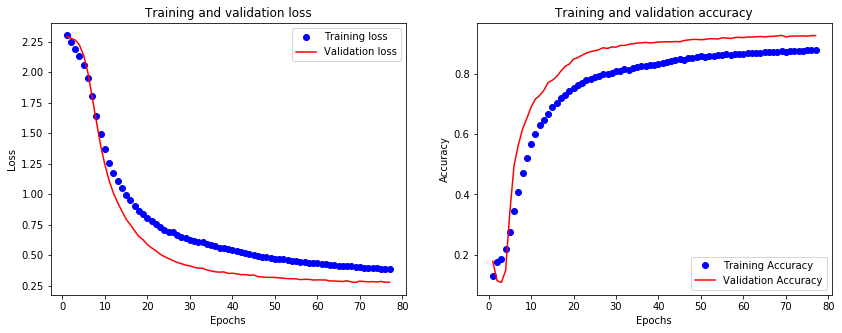

In [10]:
history_dict = history.history
history_dict.keys()

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

figure = plt.figure(figsize=(14, 5))

ax = figure.add_subplot(1, 2, 1)
# "bo" is for "blue dot"
ax.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
ax.plot(epochs, val_loss, 'r', label='Validation loss')
ax.set_title('Training and validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()


ax = figure.add_subplot(1, 2, 2)
# "bo" is for "blue dot"
ax.plot(epochs, acc, 'bo', label='Training Accuracy')
# b is for "solid blue line"
ax.plot(epochs, val_acc, 'r', label='Validation Accuracy')
ax.set_title('Training and validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()